<a href="https://colab.research.google.com/github/c-h-y-a-n/Blood-Cell-Image-Generation-by-Conditional-WGAN-GP/blob/main/notebook/WGAN_GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Preparation code in Google Colab

# Install required packages for the GAN training code
!pip install --quiet torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1 \
    --index-url https://download.pytorch.org/whl/cu121

!pip install --quiet torchinfo

!pip install --qu iet tqdm

!pip install --quiet torchmetrics

!pip install --quiet torch-fidelity

print("Installation finished.")

# link to google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# # Unzip Dataset
!unzip -q /content/drive/MyDrive/PBC_dataset_normal_DIB.zip -d /content/blood_cell_data
!rm '/content/blood_cell_data/PBC_dataset_normal_DIB/neutrophil/.DS_169665.jpg' # specific image to delete

Installation finished.
Mounted at /content/drive


In [ ]:
import os
import io
import random
from collections import defaultdict
from PIL import Image, ImageDraw, ImageFont
from IPython import display
import time
import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import spectral_norm
import torchvision
from torchvision import transforms as Transforms
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
from tqdm import tqdm
from torchmetrics.aggregation import MeanMetric
from torchmetrics.image.fid import FrechetInceptionDistance as FID
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator



%matplotlib inline
from matplotlib import pyplot as plt





In [ ]:
# Fix seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
DATA_DIR = '/content/blood_cell_data/PBC_dataset_normal_DIB'
IMAGE_SIZE = 128
CHANNELS = 3 # RGB
BATCH_SIZE = 128
Z_DIM = 100

EPOCHS = 120
CRITIC_STEPS = 7
LAMBDA = 10
ADAM_BETA_1_C = 0.0
ADAM_BETA_1_G = 0.5
ADAM_BETA_2 = 0.9
LR = 1e-4

NUM_CLASSES = 8
GEN_EMBEDDING = 100

blood_cell_labels = [
    "neutrophil",
    "eosinophil",
    "basophil",
    "lymphocyte",
    "monocyte",
    "ig",
    "erythroblast",
    "platelet"
]

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [ ]:
def save_checkpoint(epoch, generator, critic, g_optim, c_optim, history, fid_history, path="/content/drive/MyDrive/dcgan_checkpoint.pth"):
    state = {
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'critic_state_dict': critic.state_dict(),
        'g_optimizer_state_dict': g_optim.state_dict(),
        'c_optimizer_state_dict': c_optim.state_dict(),
        'history': history,
        'fid_history': fid_history
    }
    torch.save(state, path)
    print(f"--- Checkpoint saved at epoch {epoch} to {path} ---")

def load_checkpoint(path, generator, critic, g_optim, c_optim):
    if os.path.exists(path):
        print(f"Loading checkpoint from {path}...")
        checkpoint = torch.load(path, map_location = DEVICE)

        generator.load_state_dict(checkpoint['generator_state_dict'])
        critic.load_state_dict(checkpoint['critic_state_dict'])
        g_optim.load_state_dict(checkpoint['g_optimizer_state_dict'])
        c_optim.load_state_dict(checkpoint['c_optimizer_state_dict'])

        generator.to(DEVICE)
        critic.to(DEVICE)

        start_epoch = checkpoint.get('epoch', 0) + 1
        history = checkpoint.get('history', defaultdict(list))
        fid_history = checkpoint.get('fid_history', [])

        print(f"Resuming from epoch {start_epoch}")
        return start_epoch, history
    else:
        print("No checkpoint found. Starting from scratch.")
        return 0, defaultdict(list)


In [ ]:
class BloodCellData(Dataset): # from torch.utils.data
    def __init__(self, img_dir):
        super().__init__()
        self.img_dir = img_dir

        self.imgs = []
        for root, dirs, files in os.walk(img_dir):
            for file in files:
                if file.endswith('.jpeg') or file.endswith('.jpg'):
                    self.imgs.append(os.path.join(root, file))

        self.length = len(self.imgs)

        self.blood_cell_type = list(map(os.path.basename, map(os.path.dirname, self.imgs)))

        self.label = list(map(lambda x: blood_cell_labels.index(x), self.blood_cell_type))

        # Define Transformer
        self.transform = Transforms.Compose([
            Transforms.Lambda(lambda img: img.convert('RGB')),
            Transforms.ToTensor(),
            Transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            Transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
            ])



    def __len__(self):
        return self.length

    def __getitem__(self, idx): # enable indexing
        img_file = self.imgs[idx]
        image = Image.open(img_file)
        image = self.transform(image)
        label = self.label[idx]
        return image, label

def get_dataloader(suppress_print = False):
    blood_cell_dataset = BloodCellData(DATA_DIR)
    train_loader = DataLoader(blood_cell_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = 0, pin_memory = True)
    # pin_memory when we read data to CPU, it will be faster to transfer to GPU
    # num_workers defines the number of parallel subprocesses used to load data (optimal: 2 * number of GPU cores, but not recommedned for Windows)
    if not suppress_print:
        print('Train data size: ', len(blood_cell_dataset))
        print('Num. train batchs: ', len(train_loader))
    return train_loader


In [ ]:
def display_imgs(imgs, labels):
    plt.figure(figsize = (16, 3))
    for i in range(8):
        ax = plt.subplot(1, 8, i+1)
        ax.imshow(torch.clamp(imgs[i].permute(1, 2, 0)*0.5+0.5, 0.0, 1.0))
        ax.spines[['left', 'bottom']].set_visible(False)
        ax.tick_params(left=False, labelleft=False, bottom = False, labelbottom = False)
        ax.set_xlabel(blood_cell_labels[labels[i].item()])

    plt.show()

def show_records(history):
    plt.figure(figsize = (16, 3))
    for i, key in enumerate(history):
        ax = plt.subplot(1, len(history), i+1)
        ax.plot(history[key])
        ax.set_title(key)
    plt.show()

def generate_labeled_grid(model, image_per_class, num_classes):


    # Create balanced labels
    balanced_labels = torch.cat([
        torch.full((image_per_class,), cls, dtype=torch.long, device=DEVICE)
        for cls in range(num_classes)
    ])


    latents = torch.randn(image_per_class * num_classes, Z_DIM, 1, 1, device=DEVICE)

    with torch.no_grad():
        generated_imgs = wgan_gp.generator(latents, balanced_labels)
        generated_imgs = torch.clamp((generated_imgs + 1)/2, 0.0, 1.0).detach().cpu()

    # Convert to PIL images
    to_pil = Transforms.ToPILImage()
    pil_imgs = [to_pil(img) for img in generated_imgs]


    # Adjust Font
    font = ImageFont.load_default(size = 15)

    # Add label to each image
    for pil_img, lbl in zip(pil_imgs, balanced_labels):
        draw = ImageDraw.Draw(pil_img)
        text = blood_cell_labels[lbl.item()]
        draw.text((10, 10), text, fill="white", font=font, stroke_width=2, stroke_fill="black")

    # Convert back to tensor grid
    tensor_imgs = [Transforms.ToTensor()(pil_img) for pil_img in pil_imgs]
    labeled_grid = torchvision.utils.make_grid(tensor_imgs, nrow=image_per_class, normalize=True)

    return labeled_grid

Train data size:  17092
Num. train batchs:  134


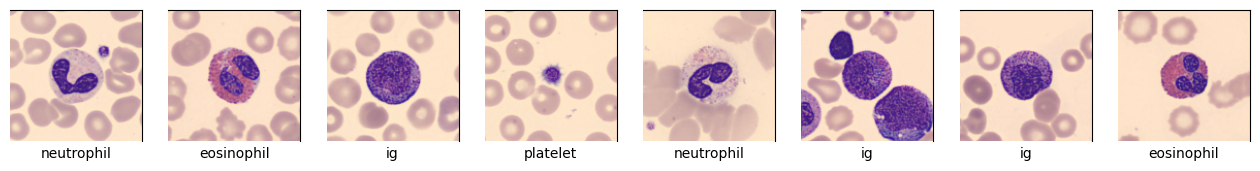

In [ ]:
train_loader = get_dataloader()
real_imgs, labels = next(iter(train_loader))
# print(real_imgs[1])
display_imgs(real_imgs, labels)

In [ ]:
# Critic Network
class Critic(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        channel_list = [CHANNELS + 1, 64, 128, 256, 512, 1024] # additional channel for labels

        self.conv_layers = nn.Sequential()
        for i in range(len(channel_list) - 1):
            conv_block = self.get_conv_block(channel_list[i], channel_list[i+1], bool(i))
            self.conv_layers.add_module(name = f'conv_block_{i+1}', module = conv_block)

        self.output_layer = nn.Sequential(
            spectral_norm(nn.Conv2d(in_channels = channel_list[-1], out_channels = 1, kernel_size=2, stride=1, padding=0, bias=False)),
            nn.Flatten()
        )

        self.image_size = IMAGE_SIZE

        self.embed = nn.Embedding(num_classes, self.image_size*self.image_size)


    def forward(self, x, labels):
        embedding = self.embed(labels).view(labels.shape[0], 1, self.image_size, self.image_size)
        x = torch.cat([x, embedding], dim=1) # concatenate in the CHANNEL dimension (batch size, CHANNEL, H, W)
        x = self.conv_layers(x)
        x = self.output_layer(x)
        return x
    def get_conv_block(self, in_channels, out_channels, use_in = True):
        layers = [
            spectral_norm(nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size=4, stride=2, padding=1, bias=False)),
            nn.LeakyReLU(0.2, inplace = False)
            # nn.Dropout2d(p = 0.3)
        ]
        if use_in:
            layers.insert(1, nn.InstanceNorm2d(out_channels))
        return nn.Sequential(*layers) # the * to unpack the list argument

test = Critic(NUM_CLASSES).to(DEVICE)
summary(test, [(1, 3, 128, 128), (1,)], dtypes=[torch.float, torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
Critic                                   [1, 9]                    --
├─Embedding: 1-1                         [1, 16384]                131,072
├─Sequential: 1-2                        [1, 1024, 4, 4]           --
│    └─Sequential: 2-1                   [1, 64, 64, 64]           --
│    │    └─Conv2d: 3-1                  [1, 64, 64, 64]           4,096
│    │    └─LeakyReLU: 3-2               [1, 64, 64, 64]           --
│    └─Sequential: 2-2                   [1, 128, 32, 32]          --
│    │    └─Conv2d: 3-3                  [1, 128, 32, 32]          131,072
│    │    └─InstanceNorm2d: 3-4          [1, 128, 32, 32]          --
│    │    └─LeakyReLU: 3-5               [1, 128, 32, 32]          --
│    └─Sequential: 2-3                   [1, 256, 16, 16]          --
│    │    └─Conv2d: 3-6                  [1, 256, 16, 16]          524,288
│    │    └─InstanceNorm2d: 3-7          [1, 256, 16, 16]          

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim, num_classes, embed_size):
        super().__init__()

        channel_list = [z_dim + embed_size, 1024, 512, 256, 128, 64] # extra channels for labels

        self.conv_trans_layers = nn.Sequential()
        for i in range(len(channel_list) - 1):
            stride = 2 if i else 1
            padding = 1 if i else 0
            trans_conv_block = self.get_conv_trans_block(channel_list[i], channel_list[i+1], stride, padding)
            self.conv_trans_layers.add_module(name = f'conv_trans_block_{i+1}',
                                              module = trans_conv_block)
        self.output_layer = nn.Sequential(
            nn.ConvTranspose2d(in_channels = channel_list[-1], out_channels = CHANNELS, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

        self.z_dim = z_dim
        self.embed_size = embed_size

        self.embed = nn.Embedding(num_classes, embed_size)

    def forward(self, x, labels):
        x = x.view(-1, self.z_dim, 1, 1)
        # reshape to (batch size, noise_dim, 1, 1)
        embedding = self.embed(labels).view(-1, self.embed_size, 1, 1)
        x = torch.cat([x, embedding], dim=1)
        x = self.conv_trans_layers(x)
        x = self.output_layer(x)
        return x

    def get_conv_trans_block(self, in_channels, out_channels, stride = 2, padding = 1):
        Layers = [
            nn.ConvTranspose2d(in_channels = in_channels, out_channels = out_channels, kernel_size=4, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(num_features = out_channels, affine = True),
            nn.ReLU(inplace=True)
        ]
        return nn.Sequential(*Layers)

generator = Generator(Z_DIM, NUM_CLASSES, GEN_EMBEDDING).to(DEVICE)
summary(generator, [(1, Z_DIM,), (1,)], dtypes=[torch.float, torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 3, 128, 128]          --
├─Embedding: 1-1                         [1, 100]                  800
├─Sequential: 1-2                        [1, 64, 64, 64]           --
│    └─Sequential: 2-1                   [1, 1024, 4, 4]           --
│    │    └─ConvTranspose2d: 3-1         [1, 1024, 4, 4]           3,276,800
│    │    └─BatchNorm2d: 3-2             [1, 1024, 4, 4]           2,048
│    │    └─ReLU: 3-3                    [1, 1024, 4, 4]           --
│    └─Sequential: 2-2                   [1, 512, 8, 8]            --
│    │    └─ConvTranspose2d: 3-4         [1, 512, 8, 8]            8,388,608
│    │    └─BatchNorm2d: 3-5             [1, 512, 8, 8]            1,024
│    │    └─ReLU: 3-6                    [1, 512, 8, 8]            --
│    └─Sequential: 2-3                   [1, 256, 16, 16]          --
│    │    └─ConvTranspose2d: 3-7         [1, 256, 16, 16]       

In [ ]:
class WGAN_GP(nn.Module):
    def __init__(self, z_dim, num_classes, embed_size):
        super().__init__()
        self.z_dim = z_dim
        self.generator = Generator(z_dim, num_classes, embed_size)
        self.critic = Critic(num_classes)
        self.critic_step = CRITIC_STEPS


    # def generate(self, real_imgs):
    #     latents = torch.randn(size = (len(real_imgs), self.z_dim, 1, 1)).to(DEVICE)
    #     generated_imgs = self.generator(latents)
    #     return generated_imgs

    def gradient_penalty(self, real_imgs, fake_imgs, labels):
        batch_size = real_imgs.size(0)
        alpha = torch.rand(batch_size, 1, 1, 1).to(DEVICE) # random weight for interpolation
        interpolated = alpha * real_imgs + (1 - alpha) * fake_imgs
        interpolated.requires_grad_(True)

        critic_interpolated = self.critic(interpolated, labels)

        gradients = torch.autograd.grad(
            outputs=critic_interpolated,
            inputs=interpolated,
            grad_outputs=torch.ones_like(critic_interpolated).to(DEVICE),
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]

        gradients = gradients.view(batch_size, -1)
        gradient_norm = gradients.norm(2, dim=1)
        penalty = ((gradient_norm - 1) ** 2).mean()
        return penalty

wgan_gp = WGAN_GP(Z_DIM, NUM_CLASSES, GEN_EMBEDDING).to(DEVICE)

In [ ]:
wgan_gp = WGAN_GP(Z_DIM, NUM_CLASSES, GEN_EMBEDDING).to(DEVICE)

if torch.__version__.split('.')[0] == '2':
    torch.set_float32_matmul_precision('high')
    # It is important to use eager backend here to avoid
    # distribution mismatch in training and predicting
    dcgan = torch.compile(wgan_gp, backend='eager')
    print('model compiled')

# loss function calculated manually in training loop
# loss_fn = nn.BCEWithLogitsLoss()

c_optim = torch.optim.Adam(params=wgan_gp.critic.parameters(), lr=LR, betas=(ADAM_BETA_1_C, ADAM_BETA_2))
g_optim = torch.optim.Adam(params=wgan_gp.generator.parameters() ,lr=LR, betas=(ADAM_BETA_1_G, ADAM_BETA_2))


train_metrics = {
    'c_wass_loss': MeanMetric(),
    'c_gp': MeanMetric(),
    'c_loss': MeanMetric(),
    'g_loss': MeanMetric()
}


model compiled


In [ ]:
def train(model, dataloader, c_optim, g_optim, train_metrics):
    model.train()

    for metrics in train_metrics.values():
        metrics.reset()


    total_steps = len(dataloader) // model.critic_step
    iter_dataloader = iter(dataloader)
    pbar = tqdm(range(total_steps), desc="Training WGAN-GP", leave = True)

    for steps in pbar:

        #1 Update Discriminator
        for j in range(model.critic_step):
            model.critic.zero_grad()

            # the real images and fake images
            try:
                train_imgs, labels = next(iter_dataloader)
            except StopIteration:
                iter_dataloader = iter(dataloader)
                train_imgs, labels = next(iter_dataloader)

            train_imgs = train_imgs.to(DEVICE)
            labels = labels.to(DEVICE)

            latents = torch.randn(size = (train_imgs.shape[0] , Z_DIM, 1, 1)).to(DEVICE)
            rnd_labels = torch.randint(0, NUM_CLASSES, (train_imgs.shape[0],)).to(DEVICE)
            generated_imgs = model.generator(latents, rnd_labels).detach() # detach to avoid backprop to generator

            # calculate EM distance and gradient penalty
            W_dist = model.critic(train_imgs, labels).mean() - model.critic(generated_imgs, rnd_labels).mean()
            gp = model.gradient_penalty(train_imgs, generated_imgs, labels)
            critic_loss = -W_dist + LAMBDA * gp # lambda for gradient penalty is 10

            critic_loss.backward()
            c_optim.step()


        # 2 Update Generator
        model.generator.zero_grad()

        # random labels for generator training
        latents = torch.randn(size = (train_imgs.shape[0] , Z_DIM, 1, 1)).to(DEVICE)
        rnd_labels = torch.randint(0, NUM_CLASSES, (train_imgs.shape[0],)).to(DEVICE)

        # generate new batch of fake images from latents
        generated_imgs_fresh = model.generator(latents, rnd_labels)

        # calculate generator loss
        g_loss = -model.critic(generated_imgs_fresh, rnd_labels).mean()
        g_loss.backward()
        g_optim.step()


        # 3 Update Metrics
        train_metrics['c_wass_loss'].update(-W_dist.detach().cpu())
        train_metrics['c_gp'].update(gp.detach().cpu())
        train_metrics['g_loss'].update(g_loss.detach().cpu())
        train_metrics['c_loss'].update(critic_loss.detach().cpu())

        pbar.set_postfix({
        "C_Loss": f"{critic_loss:.3f}",
        "G_Loss": f"{g_loss.item():.3f}",
        "GP": f"{gp.item():.4f}"
        })

    return rnd_labels, generated_imgs_fresh.detach().cpu()


Epoch: 120	epoch time 1.31 min
	 c_wass_loss: -7.5494 | c_gp: 0.0058 | c_loss: -7.4915 | g_loss: 0.5703 | 


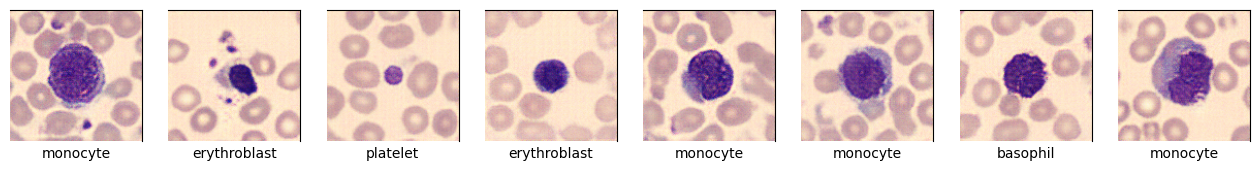

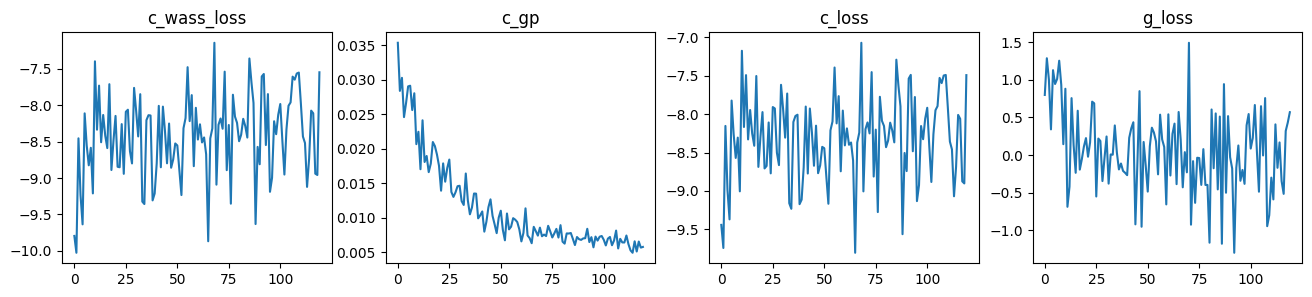


=== Running FID evaluation at epoch 120
Per-class FID: {0: 116.05575561523438, 1: 102.33600616455078, 2: 108.36466979980469, 3: 133.7161102294922, 4: 103.0719985961914, 5: 94.53067779541016, 6: 105.15118408203125, 7: 128.95867919921875}
Mean per-class FID: 111.523
--- Checkpoint saved at epoch 120 to /content/drive/MyDrive/bloodcell_wgan_gp_ckpt.pth ---


In [ ]:
bloodcell_dataloader = get_dataloader()
fid_metric = FID(normalize = True).to(DEVICE)
fid_history = list()
history = defaultdict(list)



# for model checkpoint
CHECKPOINT_PATH = '/content/drive/MyDrive/bloodcell_wgan_gp_ckpt.pth'
start_epoch, history = load_checkpoint(CHECKPOINT_PATH, wgan_gp.generator, wgan_gp.critic, g_optim, c_optim)



# for logger
writer = SummaryWriter('/content/drive/MyDrive/runs/bloodcell_experiment_final')


for i in range(start_epoch, EPOCHS):
    prev_time = time.time()
    labels, generated_imgs = train(wgan_gp, bloodcell_dataloader, c_optim, g_optim, train_metrics)
    curr_time = time.time()



    for key, value in train_metrics.items():
        history[key].append(value.compute().item())

    display.clear_output(wait=True)

    print('Epoch: {}\tepoch time {:.2f} min'.format(i+1, (curr_time - prev_time) / 60))
    metrics = [f'{key}: {value.compute().item():.4f} | ' for key, value in train_metrics.items()]
    print('\t', ''.join(metrics))

    generated_imgs = generated_imgs.detach().cpu()
    display_imgs(generated_imgs, labels)  # denormalize to [0, 1] for display
    show_records(history)


    writer.add_scalar('Wasserstein Loss/Critic', train_metrics['c_wass_loss'].compute(), i+1)
    writer.add_scalar('Gradient Penalty/Critic', train_metrics['c_gp'].compute(), i+1)
    writer.add_scalar('Loss/Generator', train_metrics['g_loss'].compute(), i+1)
    writer.add_scalar('Loss/Critic', train_metrics['c_loss'].compute(), i+1)


    if (i + 1) % 10 == 0:
        # Use make_grid to see a batch of LEGOs at once
        labeled_grid = generate_labeled_grid(wgan_gp, 8, NUM_CLASSES)
        writer.add_image('Generated_Cells', labeled_grid, i+1)

        # Evaluate and record FID
        print(f"\n=== Running FID evaluation at epoch {i + 1}")

        # Full dataset by class in defaultdict
        fid_dataloader = get_dataloader(suppress_print = True)
        real_per_class = defaultdict(list)
        for batch, (imgs, labels) in enumerate(fid_dataloader):
            for j in range(labels.shape[0]):
                lbl_scalar = labels[j].item()
                global_idx = batch * imgs.shape[0] + j # only the last batch may deviate from original batch size
                real_per_class[lbl_scalar].append(global_idx)

        fid_per_class = {}
        num_samples_per_class = 2000


        for cls in range(NUM_CLASSES):
            fid_metric.reset()

            indices = real_per_class[cls]
            n_real = min(2000, len(indices))
            if n_real == 0:
                continue

            selected_indices = random.sample(indices, n_real) if n_real < len(indices) else indices

            batch_size_gpu = 100  # safe GPU batch size; lower if still OOM

            for start in range(0, n_real, batch_size_gpu):
                end = min(start + batch_size_gpu, n_real)
                batch_idx = selected_indices[start:end]

                # load small batch on CPU
                batch_imgs = [fid_dataloader.dataset[idx][0] for idx in batch_idx]
                batch_imgs = torch.stack(batch_imgs)
                batch_imgs = torch.clamp((batch_imgs + 1)/2, 0.0, 1.0).to(DEVICE)

                # generate matching fakes
                latents = torch.randn(len(batch_idx), Z_DIM, 1, 1, device=DEVICE)
                labels = torch.full((len(batch_idx),), cls, device=DEVICE, dtype=torch.long)
                with torch.no_grad():
                    batch_fakes = wgan_gp.generator(latents, labels)
                batch_fakes = torch.clamp((batch_fakes + 1)/2, 0.0, 1.0)

                # update FID immediately (small chunk)
                fid_metric.update(batch_imgs, real=True)
                fid_metric.update(batch_fakes, real=False)

                # free memory right away
                del batch_imgs, batch_fakes, latents, labels
                torch.cuda.empty_cache()

            fid_per_class[cls] = fid_metric.compute().item()


        mean_fid = sum(fid_per_class.values()) / len(fid_per_class)
        fid_history.append((i + 1, mean_fid))
        print("Per-class FID:", fid_per_class)
        print(f"Mean per-class FID: {mean_fid:.3f}")
        fid_metric.reset()

        # save parameters and metrics to checkpoint
        save_checkpoint(i + 1, wgan_gp.generator, wgan_gp.critic, g_optim, c_optim, history, fid_history, CHECKPOINT_PATH)

        # Add FID and sample images to Summary
        for cls, val in fid_per_class.items():
            writer.add_scalar(f'FID/class_{cls}: {blood_cell_labels[cls]}', val, i+1)
        writer.add_scalar('FID/mean_per_class', mean_fid, i+1)



writer.close()


['Generated_Cells']
Images from step 120


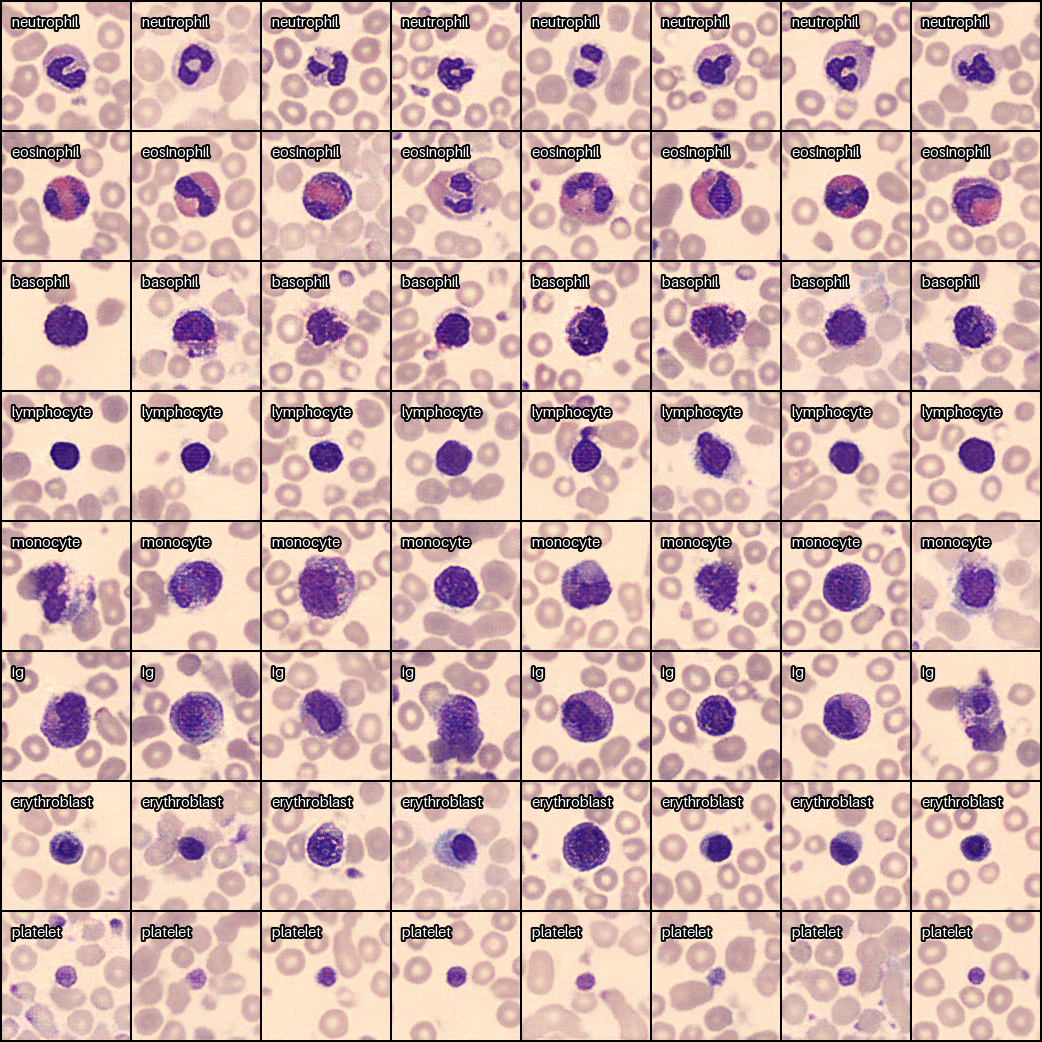

In [ ]:
# Extract sample generated images for epoch 120 from SummaryWriter

log_dir = "/content/drive/MyDrive/runs/bloodcell_experiment_final"

ea = EventAccumulator(log_dir)
ea.Reload()

# List all image tags
print(ea.Tags()['images'])

# Extract images for a specific tag and step
tag = 'Generated_Cells'  # your tag
step = 120                 # epoch/step you want

image_events = ea.Images(tag)
for event in image_events:
    if event.step == step:
        img_bytes = event.encoded_image_string
        img = Image.open(io.BytesIO(img_bytes))
        print(f"Images from step {step}")
        display.display(img)
        break

